| Task | Status | Results | Individual Responsible |
| --- | --- | --- | --- |
| **Single Layer Bidirectional GRU Model using word2vec** | Config of the model trained | Train Time = 361.73 sec | Aman, Prakash |
| Training Data Check | Confusion Matrix Built? | **Yes** |  |
|  |  | F1 Score for Positive = 0.87 |  |
|  |  | F1 Score for Negative = 0.40 |  |
|  | AUC plotted? | **Yes** | AUC = N/A |
|  | Accuracy computed? | Accuracy = 0.78 |  |
| Feature Engg | Categorical/Numerical Features Added? | Yes |  |
|  | Name 2 features added? | Tweets Cleaned, Labels |  |
| Cross Validation | Type of Cross Validation performed? | Yes |  |
|  | Findings of Cross Validation? | Average accuracy with good generalization |  |
| Interpretability | Interpretability Implemented? Local or Global? | **Yes (Local + Global)** |  |
|  | 2 interesting findings? | **Global** - _Freedom is most positive_, **Local** - _“convoy”, “message”, “skills” are the top impactful words (each with 0.06-0.07 contribution) Only One neutral “pull” (0.05 contribution)_ |  |
| Testing Data Check | Confusion Matrix Built? | **Yes** |  |
|  |  | F1 Score for Positive = 0.86 |  |
|  |  | F1 Score for Negative = 0.38 |  |
|  | AUC plotted? | **Yes** | AUC = 0.89 |
|  | Accuracy computed? | Accuracy = 0.77 |  |

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
# Load the dataset
file_path = "Sentiment_Data.csv"  # Update the path if needed

# Attempt different encodings if UTF-8 fails
encodings = ["utf-8", "ISO-8859-1", "latin1"]

for enc in encodings:
    try:
        df = pd.read_csv(file_path, encoding=enc)
        print(f"Successfully loaded with encoding: {enc}")
        break  # Stop if successful
    except UnicodeDecodeError:
        print(f"Encoding {enc} failed, trying next...")

Encoding utf-8 failed, trying next...
Successfully loaded with encoding: ISO-8859-1


In [3]:
df.head()

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451332 entries, 0 to 451331
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      451331 non-null  object
 1   Sentiment  451332 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB


In [5]:
df.isnull().sum()

Tweet        1
Sentiment    0
dtype: int64

In [6]:
df.dropna(inplace =True)

In [7]:
df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [8]:
df['Sentiment'].unique()

array(['Mild_Pos', 'Strong_Pos', 'Neutral', 'Strong_Neg', 'Mild_Neg'],
      dtype=object)

New Class Distribution:
Sentiment
Positive    297704
Neutral      77015
Negative     76612
Name: count, dtype: int64


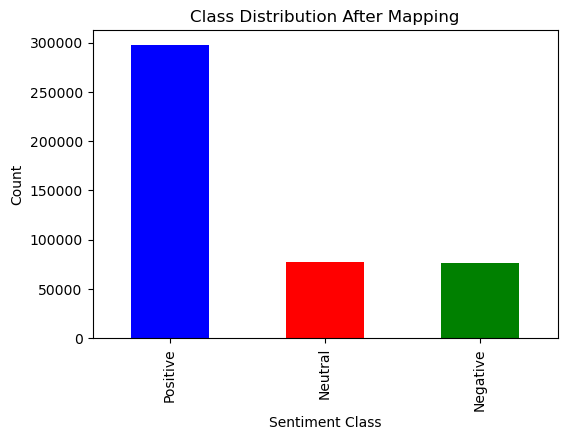

In [9]:
import matplotlib.pyplot as plt

# Map sentiments to three classes
sentiment_mapping = {
    "Mild_Pos": "Positive",
    "Strong_Pos": "Positive",
    "Mild_Neg": "Negative",
    "Strong_Neg": "Negative",
    "Neutral": "Neutral"
}

df["Sentiment"] = df["Sentiment"].map(sentiment_mapping)

# Check class distribution
print("New Class Distribution:")
print(df["Sentiment"].value_counts())

# Plot class distribution
plt.figure(figsize=(6,4))
df["Sentiment"].value_counts().plot(kind="bar", color=["blue", "red", "green"])
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.title("Class Distribution After Mapping")
plt.show()

In [24]:
import re

# Function to remove URLs
def remove_urls(text):
    return re.sub(r"http\S+|www\S+", "", text)

# Function to remove mentions and hashtags
def remove_mentions_hashtags(text):
    return re.sub(r"@\w+|#\w+", "", text)

# Apply regex transformations
df["Tweet_Cleaned"] = df["Tweet"].astype(str)
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(remove_urls)
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(remove_mentions_hashtags)

# Count regex transformations
regex_count = df["Tweet"].str.contains(r"http\S+|www\S+|@\w+|#\w+", regex=True).sum()

print(f"Regex Applied: {regex_count} changes")

Regex Applied: 405578 changes


In [30]:
import emoji

# Function to replace emojis with text equivalents
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))  # Convert emoji to text

# Apply emoji transformation
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(replace_emojis)

# Count emoji replacements
emoji_count = df["Tweet"].str.contains(r"[^\w\s,]", regex=True).sum()

print(f"Emojis Replaced: {emoji_count} emojis")

Emojis Replaced: 449126 emojis


In [28]:
# Slang dictionary
slang_dict = {
    "brb": "be right back",
    "lol": "laugh out loud",
    "idk": "I don’t know",
    "imo": "in my opinion",
    "btw": "by the way"
}

# Function to expand slangs
def expand_slang(text):
    words = text.split()
    return " ".join([slang_dict[word.lower()] if word.lower() in slang_dict else word for word in words])

# Apply slang transformation
df["Tweet_Cleaned"] = df["Tweet_Cleaned"].apply(expand_slang)

# Count slang replacements
slang_count = sum([df["Tweet"].str.contains(word, case=False, na=False).sum() for word in slang_dict.keys()])

print(f"Slangs Expanded: {slang_count} slangs")

Slangs Expanded: 7142 slangs


In [40]:
# Display a few cleaned tweets
print("\nSample Cleaned Tweets:")
df[["Tweet", "Tweet_Cleaned"]].head()


Sample Cleaned Tweets:


,Tweet,Tweet_Cleaned
0,@_angelica_toy Happy Anniversary!!!....The Day...,Happy Anniversary!!!....The Day the FreeDUMB D...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Happy Anniversary!!!....The Day the FreeDUMB D...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Happy Anniversary!!!....The Day the FreeDUMB D...
3,@NChartierET Happy Anniversary!!!....The Day t...,Happy Anniversary!!!....The Day the FreeDUMB D...
4,@tabithapeters05 Happy Anniversary!!!....The D...,Happy Anniversary!!!....The Day the FreeDUMB D...


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text into TF-IDF features
vectorizer = TfidfVectorizer(max_features=500)  # Use top 500 words
X_tfidf = vectorizer.fit_transform(df["Tweet_Cleaned"])

# Convert to DataFrame for analysis
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df["Sentiment"] = df["Sentiment"]

print("TF-IDF feature shape:", X_tfidf.shape)
tfidf_df.head()

TF-IDF feature shape: (451331, 500)


,000,10,100,19,2022,about,account,accounts,across,act,...,yes,yet,you,your,youâ,ªã,³ã,ºð,ï¼,Sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Positive


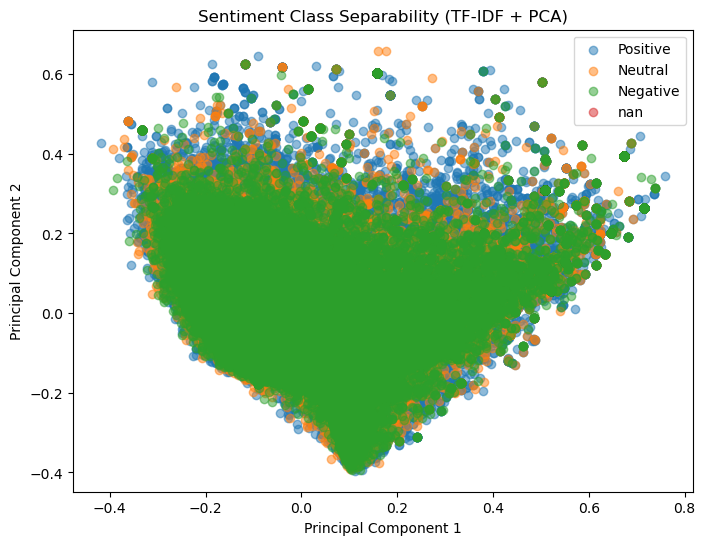

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Convert to DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Sentiment"] = df["Sentiment"]

# Plot PCA visualization
plt.figure(figsize=(8,6))
for sentiment in pca_df["Sentiment"].unique():
    subset = pca_df[pca_df["Sentiment"] == sentiment]
    plt.scatter(subset["PC1"], subset["PC2"], label=sentiment, alpha=0.5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Sentiment Class Separability (TF-IDF + PCA)")
plt.legend()
plt.show()

In [58]:
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import nltk

In [60]:
# Tokenize each tweet into words
df["Tokenized_Tweet"] = df["Tweet_Cleaned"].apply(lambda x: word_tokenize(x.lower()))

# Display sample tokenized tweets
df[["Tweet_Cleaned", "Tokenized_Tweet"]].head()

,Tweet_Cleaned,Tokenized_Tweet
0,Happy Anniversary!!!....The Day the FreeDUMB D...,"[happy, anniversary, !, !, !, ...., the, day, ..."
1,Happy Anniversary!!!....The Day the FreeDUMB D...,"[happy, anniversary, !, !, !, ...., the, day, ..."
2,Happy Anniversary!!!....The Day the FreeDUMB D...,"[happy, anniversary, !, !, !, ...., the, day, ..."
3,Happy Anniversary!!!....The Day the FreeDUMB D...,"[happy, anniversary, !, !, !, ...., the, day, ..."
4,Happy Anniversary!!!....The Day the FreeDUMB D...,"[happy, anniversary, !, !, !, ...., the, day, ..."


In [62]:
# Configurable parameters
embedding_size = 100  # Choose between 64-300
window_size = 5       # Context window size
min_word_count = 2    # Ignore words with <2 occurrences
model_type = 1        # 0 = CBOW, 1 = Skip-gram

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=df["Tokenized_Tweet"],
    vector_size=embedding_size,
    window=window_size,
    min_count=min_word_count,
    sg=model_type,  # 0 = CBOW, 1 = Skip-gram
    workers=4
)

# Save the model for reuse
w2v_model.save("word2vec_model.bin")
print("Word2Vec model trained and saved!")

Word2Vec model trained and saved!


In [64]:
import numpy as np

# Function to get average word embedding for a tweet
def tweet_to_vec(tweet, model, embedding_size):
    vectors = [model.wv[word] for word in tweet if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_size)

# Convert all tweets to their respective embedding vectors
df["Tweet_Vector"] = df["Tokenized_Tweet"].apply(lambda x: tweet_to_vec(x, w2v_model, embedding_size))

# Display sample vectors
print("\nSample Tweet Embeddings:")
df["Tweet_Vector"].head()


Sample Tweet Embeddings:


0    [0.1695116, 0.0073538986, -0.25935444, 0.26921...
1    [0.1695116, 0.0073538986, -0.25935444, 0.26921...
2    [0.1695116, 0.0073538986, -0.25935444, 0.26921...
3    [0.1695116, 0.0073538986, -0.25935444, 0.26921...
4    [0.1695116, 0.0073538986, -0.25935444, 0.26921...
Name: Tweet_Vector, dtype: object

In [66]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_labels = ["Positive", "Neutral", "Negative"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(class_labels),
    y=df["Sentiment"]
)

# Convert to dictionary format for PyTorch
class_weights_dict = {label: weight for label, weight in zip(class_labels, class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {'Positive': 0.5053464739024893, 'Neutral': 1.953433313856608, 'Negative': 1.9637089054804295}


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import time

In [70]:
# Convert labels to numeric format
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Sentiment"])  # 0 = Negative, 1 = Neutral, 2 = Positive

# Convert to NumPy arrays
X = np.array(df["Tweet_Vector"].tolist())
y = np.array(df["Label"])

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoaders
batch_size = 64
train_dataset = SentimentDataset(X_train_tensor, y_train_tensor)
test_dataset = SentimentDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:
class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.3):
        super(BiGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Bi-directional output
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension
        gru_out, _ = self.gru(x)
        out = self.dropout(gru_out[:, -1, :])  # Last output from Bi-GRU
        out = self.fc(out)
        return out

# Model Parameters
input_size = X_train.shape[1]  # Embedding size (Word2Vec)
hidden_size = 128
output_size = len(np.unique(y))  # 3 classes (Positive, Neutral, Negative)
num_layers = 1

# Initialize Model
model = BiGRU(input_size, hidden_size, output_size, num_layers)
print(model)

BiGRU(
  (gru): GRU(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [74]:
# Convert class weights to tensor for PyTorch
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float32)

# Define loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model & tensors to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [78]:
from sklearn.metrics import accuracy_score

num_epochs = 50  # Max epochs
patience = 5  # Early stopping patience
best_val_loss = float("inf")
early_stop_count = 0

results = []

print("Training Started...")
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    y_train_pred, y_train_true = [], []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(batch_y.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    y_val_pred, y_val_true = [], []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_val_pred.extend(predicted.cpu().numpy())
            y_val_true.extend(batch_y.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    avg_val_loss = total_val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_count = 0
        torch.save(model, "best_biGRU_model.pth")  # Save best model
    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print("Early stopping triggered!")
        break

training_time = time.time() - start_time
print(f"Training Completed in {training_time:.2f} seconds")

Training Started...
Epoch [1/50] - Train Loss: 0.4956 | Train Acc: 0.7223 | Val Loss: 0.4844 | Val Acc: 0.7304
Epoch [2/50] - Train Loss: 0.4834 | Train Acc: 0.7290 | Val Loss: 0.4743 | Val Acc: 0.7349
Epoch [3/50] - Train Loss: 0.4744 | Train Acc: 0.7340 | Val Loss: 0.4644 | Val Acc: 0.7341
Epoch [4/50] - Train Loss: 0.4675 | Train Acc: 0.7375 | Val Loss: 0.4618 | Val Acc: 0.7367
Epoch [5/50] - Train Loss: 0.4613 | Train Acc: 0.7407 | Val Loss: 0.4536 | Val Acc: 0.7407
Epoch [6/50] - Train Loss: 0.4560 | Train Acc: 0.7439 | Val Loss: 0.4497 | Val Acc: 0.7545
Epoch [7/50] - Train Loss: 0.4515 | Train Acc: 0.7460 | Val Loss: 0.4440 | Val Acc: 0.7478
Epoch [8/50] - Train Loss: 0.4471 | Train Acc: 0.7480 | Val Loss: 0.4426 | Val Acc: 0.7499
Epoch [9/50] - Train Loss: 0.4434 | Train Acc: 0.7508 | Val Loss: 0.4375 | Val Acc: 0.7601
Epoch [10/50] - Train Loss: 0.4399 | Train Acc: 0.7524 | Val Loss: 0.4356 | Val Acc: 0.7514
Epoch [11/50] - Train Loss: 0.4369 | Train Acc: 0.7538 | Val Loss: 0.

In [98]:
import numpy as np

model.eval()

y_pred, y_true, y_probs = [], [], []
y_train_pred, y_train_true = [], []

# Evaluate on Test Data
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(batch_y.cpu().numpy())
        y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Evaluate on Train Data
with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        y_train_pred.extend(predicted.cpu().numpy())
        y_train_true.extend(batch_y.cpu().numpy())

# Compute Metrics
train_accuracy = accuracy_score(y_train_true, y_train_pred)
test_accuracy = accuracy_score(y_true, y_pred)

train_report = classification_report(y_train_true, y_train_pred, target_names=label_encoder.classes_, output_dict=True)
test_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

test_auc = roc_auc_score(y_true, y_probs, multi_class="ovr")

# Create a structured DataFrame with two rows: Training & Testing
results_df = pd.DataFrame([
    {
        "Metric": "Training",
        "Accuracy": train_accuracy,
        "AUC": np.nan,  # AUC not computed for training
        "F1_Positive": train_report["Positive"]["f1-score"],
        "F1_Neutral": train_report["Neutral"]["f1-score"],
        "F1_Negative": train_report["Negative"]["f1-score"],
        "Training Time (s)": training_time
    },
    {
        "Metric": "Testing",
        "Accuracy": test_accuracy,
        "AUC": test_auc,
        "F1_Positive": test_report["Positive"]["f1-score"],
        "F1_Neutral": test_report["Neutral"]["f1-score"],
        "F1_Negative": test_report["Negative"]["f1-score"],
        "Training Time (s)": np.nan  # Not applicable for testing
    }
])

# Save results
results_df.to_csv("BiGRU_Results.csv", index=False)

print("\nModel Evaluation:")
print("\nResults saved as 'BiGRU_Results.csv'.")


Model Evaluation:

Results saved as 'BiGRU_Results.csv'.


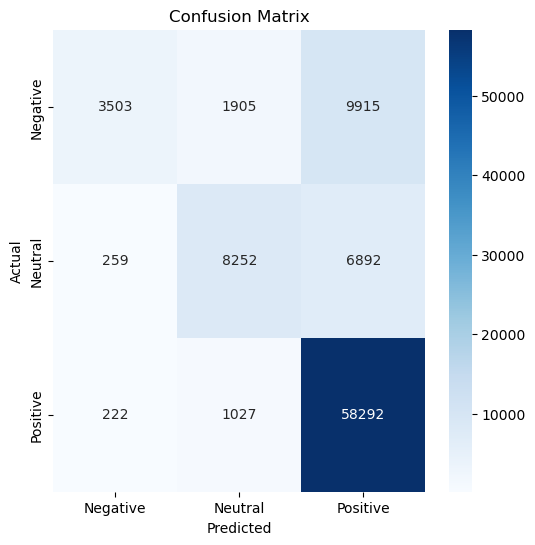

In [100]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

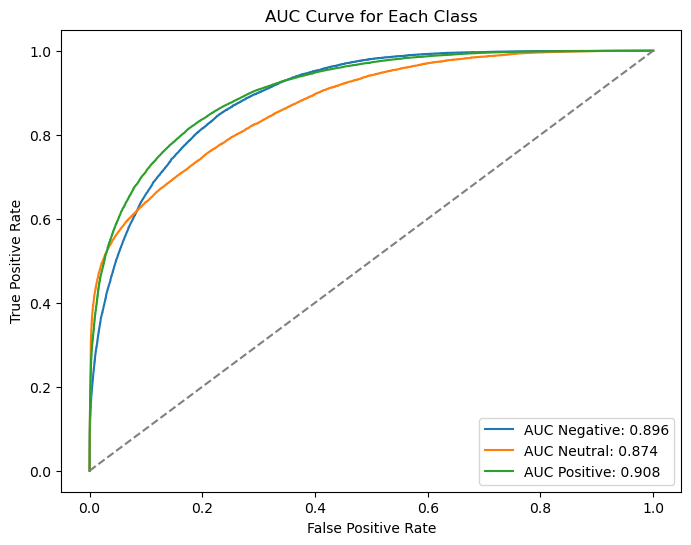

In [102]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Convert labels to binary format for AUC
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])

plt.figure(figsize=(8,6))
for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], np.array(y_probs)[:, i])
    plt.plot(fpr, tpr, label=f"AUC {label}: {auc(fpr, tpr):.3f}")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve for Each Class")
plt.legend()
plt.show()

In [104]:
results_df

,Metric,Accuracy,AUC,F1_Positive,F1_Neutral,F1_Negative,Training Time (s)
0,Training,0.784764,NaN,0.871102,0.643647,0.379109,802.291292
1,Testing,0.775998,0.892568,0.865894,0.620755,0.362874,NaN


In [108]:
import torch

# Function to compute gradients of the predicted class with respect to input
def get_word_importance(model, tweet_vector):
    model.train()  # Temporarily enable training mode for gradients
    tweet_tensor = torch.tensor(tweet_vector, dtype=torch.float32).unsqueeze(0).to(device)
    tweet_tensor.requires_grad_()

    # Forward pass
    output = model(tweet_tensor)
    predicted_class = torch.argmax(output, dim=1)

    # Compute gradients
    model.zero_grad()  # Clear previous gradients
    output[0, predicted_class].backward(retain_graph=True)
    importance = tweet_tensor.grad.abs().squeeze(0).cpu().numpy()

    model.eval()  # Switch back to evaluation mode
    return importance, predicted_class.item()

# Select a random tweet for interpretation
sample_index = np.random.randint(0, len(df))
sample_tweet = df.iloc[sample_index]["Tweet_Cleaned"]
sample_vector = df.iloc[sample_index]["Tweet_Vector"]
sample_tokens = df.iloc[sample_index]["Tokenized_Tweet"]

# Get word importance scores
importance_scores, predicted_label = get_word_importance(model, sample_vector)

# Print interpretation
print("\n🔍 Interpretation of Sample Tweet:")
print(f"Tweet: {sample_tweet}")
print(f"Predicted Sentiment: {label_encoder.classes_[predicted_label]}")

# Display words with their importance scores
word_importance = list(zip(sample_tokens, importance_scores))
word_importance.sort(key=lambda x: x[1], reverse=True)  # Sort by importance

print("\n🌟 Word Importance Scores:")
for word, score in word_importance[:10]:  # Display top 10 words
    print(f"{word}: {score:.4f}")


🔍 Interpretation of Sample Tweet:
Tweet: Funny not a word from you on whatâs been happening in Yemen Syria or Palestine by the way did your brotherâs bank account get frozen after his donation to the freedom convoy
Predicted Sentiment: Positive

🌟 Word Importance Scores:
on: 2.4658
to: 2.3877
way: 2.0260
from: 1.6396
word: 1.6081
whatâs: 1.6056
frozen: 1.5050
not: 1.2825
freedom: 1.2469
his: 1.2291


C:\Users\chetn\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128 (\x80) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chetn\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 153 (\x99) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


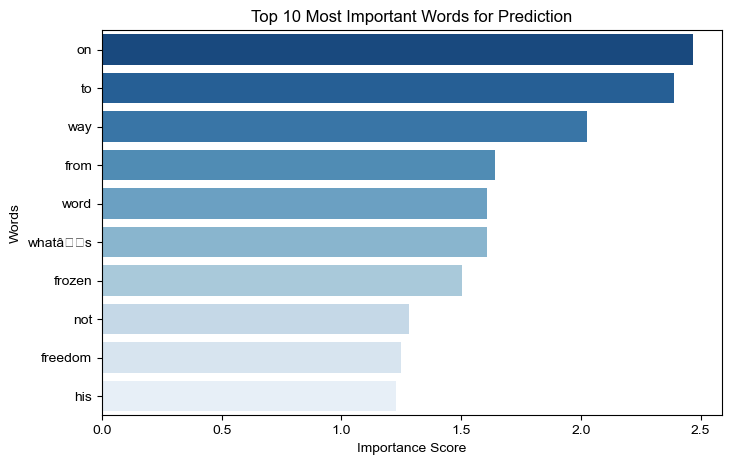

In [128]:
# Select top 10 most important words
top_words, top_scores = zip(*word_importance[:10])

# Create DataFrame for Seaborn
importance_df = pd.DataFrame({"Word": top_words, "Importance Score": top_scores})

# Plot using Seaborn (Fixed)
plt.figure(figsize=(8, 5))
sns.barplot(y="Word", x="Importance Score", data=importance_df, hue="Word", legend=False, palette="Blues_r")
plt.xlabel("Importance Score")
plt.ylabel("Words")
plt.title("Top 10 Most Important Words for Prediction")
plt.show()

In [130]:
import lime
from lime.lime_text import LimeTextExplainer

# Function to make predictions for LIME
def lime_predict(texts):
    vectors = [tweet_to_vec(word_tokenize(text.lower()), w2v_model, X_train.shape[1]) for text in texts]
    tensors = torch.tensor(vectors, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(tensors)
    return torch.softmax(outputs, dim=1).cpu().numpy()

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=label_encoder.classes_)

In [132]:
# Explain a random sample tweet
lime_exp = explainer.explain_instance(sample_tweet, lime_predict, num_features=10)

# Show LIME explanation
lime_exp.show_in_notebook()

C:\Users\chetn\AppData\Local\Temp\ipykernel_13324\2518617297.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  tensors = torch.tensor(vectors, dtype=torch.float32).to(device)


In [151]:
import numpy as np
from collections import defaultdict
from lime.lime_text import LimeTextExplainer
from joblib import Parallel, delayed

# Re-initialize LIME Explainer
explainer = LimeTextExplainer(class_names=label_encoder.classes_)

# Optimized function to run LIME on multiple tweets in parallel
def explain_single_tweet(tweet, top_features):
    try:
        lime_exp = explainer.explain_instance(tweet, lime_predict, num_features=top_features, num_samples=500)
        return lime_exp.as_list()
    except Exception as e:
        return []  # Skip tweets that cause errors

def optimized_global_lime(n_samples=50, top_features=5):
    word_importance = defaultdict(float)

    # Ensure we don't select more samples than available
    n_samples = min(n_samples, len(df))
    
    # Select random tweets
    sample_tweets = df.sample(n=n_samples, random_state=42)["Tweet_Cleaned"].tolist()

    # Run LIME in parallel (multi-threaded for speed)
    explanations = Parallel(n_jobs=-1)(
        delayed(explain_single_tweet)(tweet, top_features) for tweet in sample_tweets
    )

    # Aggregate feature importance
    for exp in explanations:
        for word, score in exp:
            word_importance[word] += abs(score)

    # Sort words by importance
    sorted_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)[:top_features]
    
    return sorted_words

# Run Optimized Global LIME
global_lime_results = optimized_global_lime(n_samples=50, top_features=10)

# Display top influential words globally
print("\n Optimized Global LIME: Most Influential Words Across Multiple Samples")
for word, score in global_lime_results:
    print(f"{word}: {score:.4f}")


 Optimized Global LIME: Most Influential Words Across Multiple Samples
Freedom: 6.6706
freedom: 1.9431
Convoy: 1.0773
die: 0.6213
FREEDOM: 0.5327
convoy: 0.5099
Emergency: 0.4866
exchanged: 0.2367
Convoyâ: 0.2290
like: 0.2225


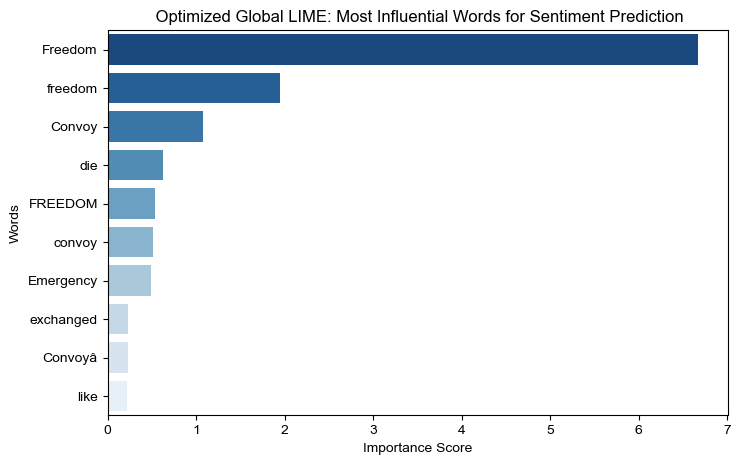

In [153]:
# Convert results into DataFrame
lime_global_df = pd.DataFrame(global_lime_results, columns=["Word", "Importance Score"])

# Plot using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(y="Word", x="Importance Score", data=lime_global_df, hue="Word", legend=False, palette="Blues_r")
plt.xlabel("Importance Score")
plt.ylabel("Words")
plt.title(" Optimized Global LIME: Most Influential Words for Sentiment Prediction")
plt.show()